In [1]:
import scipy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
_, data48kHz = scipy.io.wavfile.read("ash_48kHz.wav")
amplitude = np.iinfo(np.int16).max
data16kHz = scipy.signal.resample(x=data48kHz, num=len(data48kHz)//3)
scipy.io.wavfile.write(filename="ash_16kHz.wav", rate=16000, data=data16kHz)

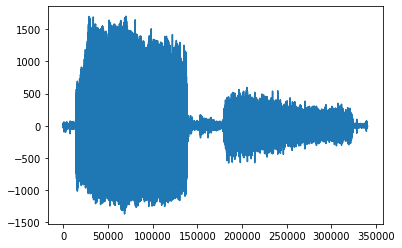

In [3]:
rate, data = scipy.io.wavfile.read("ash_16kHz.wav")
plt.plot(data)

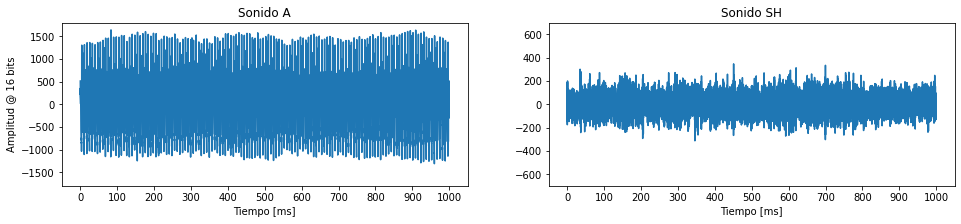

In [24]:
data_a = data[50000:50000+rate]
data_sh = data[300000:300000+rate]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,3))
ax1.plot(data_a)
ax2.plot(data_sh)
ax1.set_title("Sonido A")
ax2.set_title("Sonido SH")
ax1.set_xlabel("Tiempo [ms]")
ax2.set_xlabel("Tiempo [ms]")
ax1.set_ylabel("Amplitud @ 16 bits")
ax1.set_ylim(bottom=-1800, top=1800)
ax2.set_ylim(bottom=-700, top=700)
ax1.set_xticks([1600*x for x in range(11)])
ax1.set_xticklabels([f"{100*x}" for x in range(11)])
ax2.set_xticks([1600*x for x in range(11)])
ax2.set_xticklabels([f"{100*x}" for x in range(11)])
plt.show()

In [25]:
def autocorrelation(data, N, L):
    x = data[:N]
    lags = [x for x in range(0, L)]
    rxx = scipy.signal.correlate(in1=x,in2=x, mode="full", method="fft") / N
    rxx = rxx[N: N+L]
    return lags, rxx

def plot_rxx(data, title, N=16000, L=500):
    lags, rxx = autocorrelation(data, N, L)
    plt.figure(figsize=(8,3))
    plt.plot(lags, rxx)
    plt.ylabel(r"$r_{xx}(\tau)$", rotation=0, labelpad=10)
    plt.xlabel(r"$\tau$")
    plt.title(title)
    plt.show()

Se aprecia que la señal A es casi estacionaria dado que la autocorrelación es casi periódica.

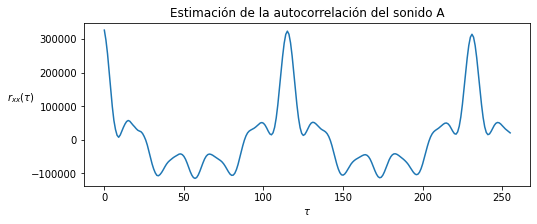

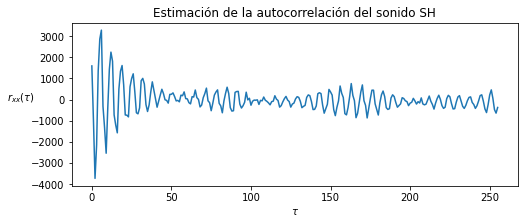

In [36]:
plot_rxx(data_a, "Estimación de la autocorrelación del sonido A", N=16000, L =256)
plot_rxx(data_sh, "Estimación de la autocorrelación del sonido SH", N=1600, L=256)


$\mathbf{R}(n) = E[\mathbf{x}(n)\mathbf{x}^H(n)]$

$\mathbf{r}^f(n) = E[\mathbf{x}(n-1){x}^*(n)]$

Ecuaciones normales:
$\mathbf{R}(n-1)\mathbf{a}_o(n) = -\mathbf{r}^f(n)$

MMSE:
$J_o^f = \sigma_x^2(n) + \mathbf{r}^{fH}(n)\mathbf{a}_o(n)$ 

In [27]:
def flp(data, M):
    lags, rxx = autocorrelation(data, N=16000, L=500)

    # Input data vector x=x(n-1)
    x = data[:M][::-1] # x(n-1) = [x(n-1) x(n-2) ... x(n-M)]

    c=rxx[:M] # c = [r(0) ... r(M-1)]
    R = scipy.linalg.toeplitz(c=c)
    rf = rxx[1:M+1] # rf = [r(1) ... r(M)]
    
    # Solve normal equations
    ao = scipy.linalg.solve_toeplitz(c_or_cr=c, b=-rf)
    Jo = np.var(data) + np.array(rf) @ np.array(ao)
    return Jo

In [31]:
def plot_mmse_vs_order(data, max_order, title):
    mmse = []
    order = [M for M in range(1,max_order+1)]
    for M in order:
        mmse.append(flp(data, M))

    plt.figure(figsize=(8,3))
    plt.plot(order, mmse, '.')
    plt.title(title)
    plt.xlabel("Orden del predictor")
    plt.ylabel("MMSE")
    plt.show()

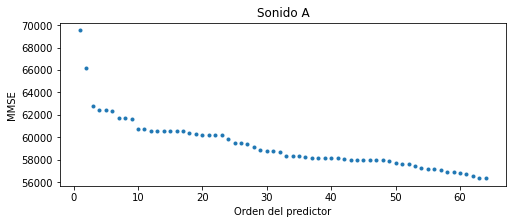

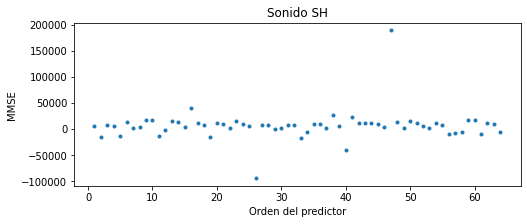

In [38]:
plot_mmse_vs_order(data_a, 64, "Sonido A")
plot_mmse_vs_order(data_sh, 64, "Sonido SH")